Exploratory Analysis of the MIMIC-III database. This subset includes patients with the sepsis ICD-9 code.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
final = pd.read_csv('Final/final.csv')
dob = pd.read_csv('Final/dob2.csv')
icu = pd.read_csv('Final/icustay.csv')
icd = pd.read_csv('Final/number_of_icd.csv')
meds = pd.read_csv('Final/number_of_meds.csv')

In [3]:
final.describe()

,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
count,4555.000000,4555.000000,4555.000000,4555.0
mean,40834.167947,149304.086937,0.371679,1.0
std,29659.166297,28592.413555,0.483306,0.0
min,21.000000,100028.000000,0.000000,1.0
25%,15607.500000,124922.000000,0.000000,1.0
50%,30202.000000,149165.000000,0.000000,1.0
75%,66000.500000,174062.500000,1.000000,1.0
max,99991.000000,199943.000000,1.000000,1.0


In [4]:
# Merge final and dob
final_dob = final.merge(dob, left_on=['SUBJECT_ID','HADM_ID'], right_on=['SUBJECT_ID','HADM_ID'])
final_dob['DOB'] = final_dob['DOB'].str.replace("T", " ")
final_dob['DOB'] = final_dob['DOB'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
final_dob['ADMITTIME'] = final_dob['ADMITTIME'].str.replace("T", " ")
final_dob['ADMITTIME'] = final_dob['ADMITTIME'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
final_dob['AGE'] = abs(final_dob['ADMITTIME'] - final_dob['DOB'])
final_dob['AGE'] = final_dob['AGE']/np.timedelta64(1,'Y')
df = final_dob.merge(icd, left_on='SUBJECT_ID', right_on='SUBJECT_ID')
df = df[(df['AGE'] > 1)]

expired = []
for row in df.iterrows():
    if str(row[1]['DOD_HOSP']) == 'nan' and row[1]['HOSPITAL_EXPIRE_FLAG'] == 0:
        expired.append(0)
    else:
        expired.append(1)
df['EXPIRED_FLAG'] = expired

## AGE

In [5]:
df['AGE'].describe()

count    4554.000000
mean       81.916901
std        59.640926
min        18.022058
25%        56.254093
50%        68.695120
75%        80.415784
max       284.553357
Name: AGE, dtype: float64

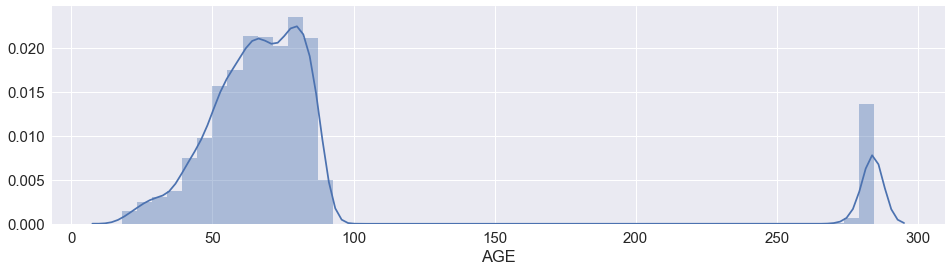

In [6]:
plt.figure(figsize=(16,4))
sns.set(font_scale = 1.5)
sns.distplot(df['AGE'])

In [7]:
# expired pts

df['AGE'][(df['EXPIRED_FLAG'] == 1)].describe()

count    2225.000000
mean       87.267826
std        63.144928
min        20.580220
25%        59.822492
50%        71.428661
75%        82.388858
max       284.553279
Name: AGE, dtype: float64

## LOS

In [8]:
icu_df = df.merge(icu, left_on='SUBJECT_ID', right_on='SUBJECT_ID')

In [9]:
icu_df['LOS'].describe()

count    9419.000000
mean        6.090338
std         8.825598
min         0.006600
25%         1.659600
50%         2.967100
75%         6.762850
max       173.072500
Name: LOS, dtype: float64

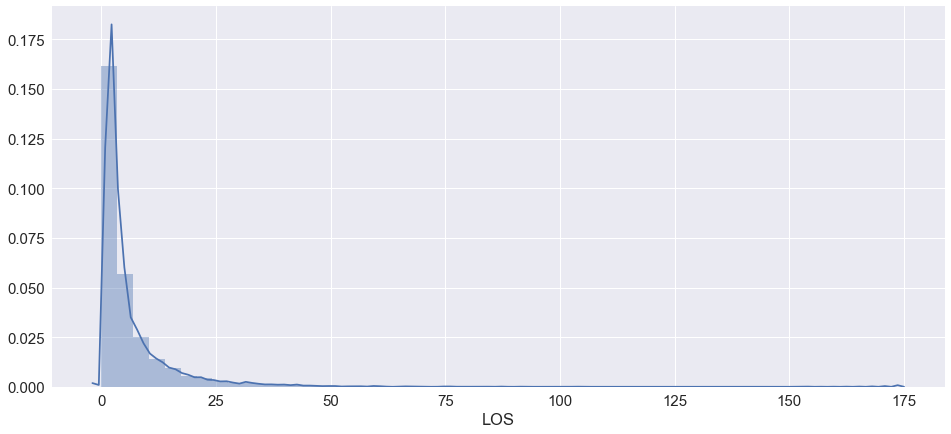

In [10]:
plt.figure(figsize=(16,7))
sns.distplot(icu_df['LOS'])

In [11]:
# patients expired
icu_df['LOS'][(icu_df['EXPIRED_FLAG'] == 1)].describe()

count    4974.000000
mean        6.242165
std         8.713466
min         0.007100
25%         1.612725
50%         3.065450
75%         7.138475
max       153.928000
Name: LOS, dtype: float64

In [12]:
# patients aggregated
icu_agg = icu_df.groupby(icu_df['SUBJECT_ID']).aggregate({'LOS': 'sum'})
icu_agg.describe()

,LOS
count,4553.000000
mean,12.599361
std,16.625461
min,0.158300
25%,2.839800
50%,6.736500
75%,15.820600
max,268.624500


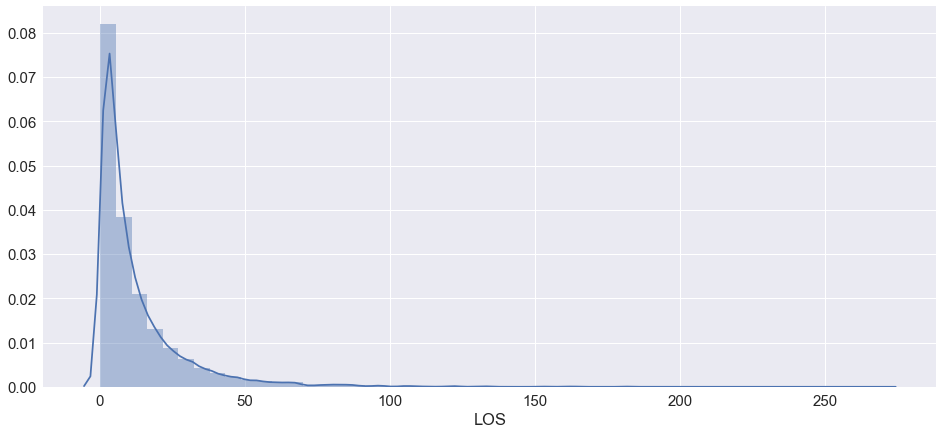

In [13]:
plt.figure(figsize=(16,7))
sns.distplot(icu_agg['LOS'])

In [14]:
# patients expired (aggregated)
expired = icu_df[(icu_df['EXPIRED_FLAG'] == 1)]
expired = expired.groupby(expired['SUBJECT_ID']).aggregate({'LOS': 'sum'})
expired['LOS'].describe()

count    2225.000000
mean       13.954395
std        17.219267
min         0.158300
25%         3.192500
50%         7.984100
75%        17.991800
max       181.873500
Name: LOS, dtype: float64

## Num of Conditions (by ICD)

In [15]:
df['ICD'].describe()

count    4554.000000
mean       25.508564
std        15.376183
min         3.000000
25%        15.000000
50%        21.000000
75%        32.000000
max       144.000000
Name: ICD, dtype: float64

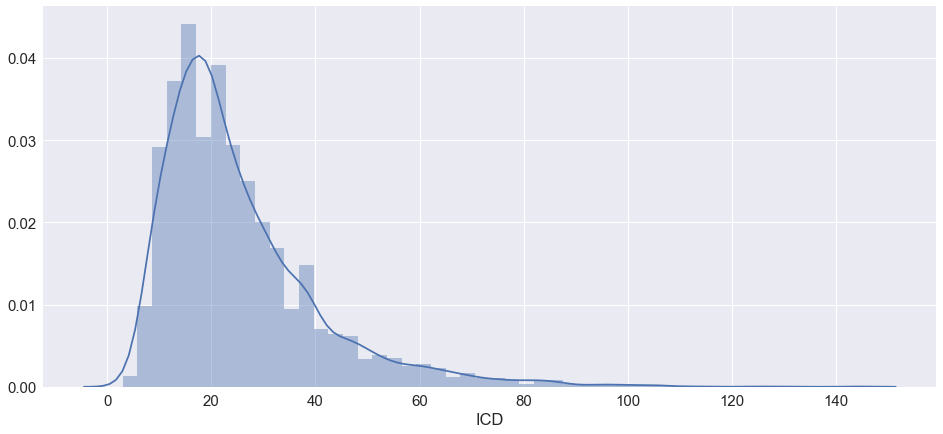

In [16]:
plt.figure(figsize=(16,7))
sns.distplot(df['ICD'])

## Num of Meds (by NDC)

In [17]:
meds.describe()

,SUBJECT_ID,MEDS
count,4551.000000,4551.000000
mean,40825.144803,73.027466
std,29655.152079,42.370354
min,21.000000,2.000000
25%,15607.500000,41.000000
50%,30202.000000,64.000000
75%,66000.500000,94.000000
max,99991.000000,346.000000


## Gender Frequency & Distribution

In [18]:
gend = df['GENDER'].value_counts()
gend

M    2525
F    2029
Name: GENDER, dtype: int64

In [19]:
gender = {}
for mf, count in gend.items():
    gender[mf] = round(count / len(df['GENDER']),2)
gender

{'F': 0.45000000000000001, 'M': 0.55000000000000004}

## Survived vs. Expired Frequency & Distribution

In [20]:
expired = df['EXPIRED_FLAG'].value_counts()
expired
xprd = {}
for flag, count in expired.items():
    xprd[flag] = round(count / len(df['EXPIRED_FLAG']),2)
xprd

{0: 0.51000000000000001, 1: 0.48999999999999999}

In [21]:
expired

0    2329
1    2225
Name: EXPIRED_FLAG, dtype: int64

## Gender vs. Survival

In [22]:
gender_exp_no = df['GENDER'][(df['EXPIRED_FLAG'] == 0)].value_counts().reset_index().rename(columns={'index': 'GENDER',
                                                                                                     'GENDER': 'surv_count'})
gender_exp_yes = df['GENDER'][(df['EXPIRED_FLAG'] == 1)].value_counts().reset_index().rename(columns={'index': 'GENDER',
                                                                                     'GENDER': 'exp_count'})
gender_exp = gender_exp_yes.merge(gender_exp_no, left_on='GENDER', right_on='GENDER')
gender_exp['total'] =  gender_exp_no['surv_count'] + gender_exp_yes['exp_count']
gender_exp

,GENDER,exp_count,surv_count,total
0,M,1279,1246,2525
1,F,946,1083,2029


In [23]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_context({"figure.figsize": (6, 5)})

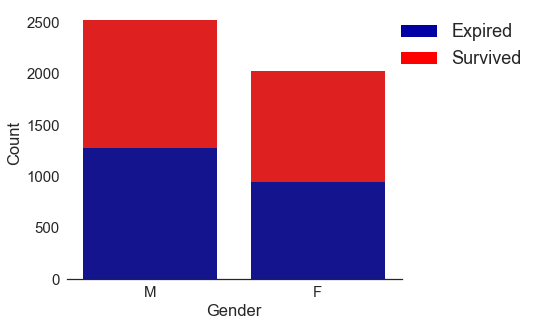

In [24]:
sns.barplot(x = gender_exp.GENDER, y = gender_exp.total, color= "red")
bottom_plot = sns.barplot(x = gender_exp.GENDER, y = gender_exp.exp_count, color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Expired', 'Survived'], bbox_to_anchor=(0.95, 1), prop={'size':18})
l.draw_frame=(True)

sns.despine(left=True)
bottom_plot.set_ylabel("Count")
bottom_plot.set_xlabel("Gender")

In [25]:
exp_gender_M = df['EXPIRED_FLAG'][(df['GENDER'] == 'M')].value_counts().reset_index().rename(columns={'index': 'EXPIRED',
                                                                                    'EXPIRED_FLAG': 'Male'})
exp_gender_F = df['EXPIRED_FLAG'][(df['GENDER'] == 'F')].value_counts().reset_index().rename(columns={'index': 'EXPIRED',
                                                                                     'EXPIRED_FLAG': 'Female'})
exp_gender = exp_gender_M.merge(exp_gender_F, left_on='EXPIRED', right_on='EXPIRED')
exp_gender['total'] =  exp_gender['Male'] + exp_gender['Female']
exp_gender

,EXPIRED,Male,Female,total
0,1,1279,946,2225
1,0,1246,1083,2329


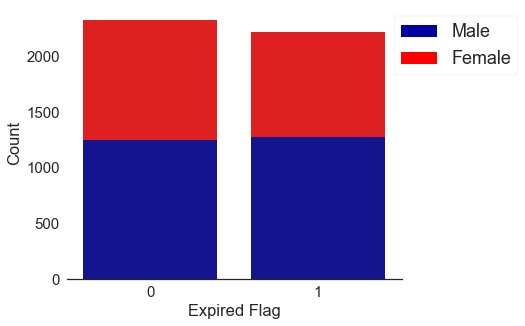

In [26]:
sns.barplot(x = exp_gender.EXPIRED, y = exp_gender.total, color= "red")
bottom_plot = sns.barplot(x = exp_gender.EXPIRED, y = exp_gender.Male, color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Male', 'Female'], bbox_to_anchor=(0.95, 1), prop={'size':18})
l.draw_frame(True)

sns.despine(left=True)
bottom_plot.set_ylabel("Count")
bottom_plot.set_xlabel("Expired Flag")